# A Look at Bicycle Commuting and Health in the United States – Part I 

The U.S. Department of Transportation recently partnered with the Centers for Disease Control (CDC) and the American Public Health Association (APHA) to release data on transportation and public health indicators for each U.S. state and metropolitan area. The purpose of the data release, available via the [Transportation and Health Tool (THT)](https://www.transportation.gov/transportation-health-tool) as well as [Data.gov](https://catalog.data.gov/dataset/transportation-and-health-tool-data), is to provide practitioners with the data that they need to make informed decisions when planning changes in transportation infrastructure.

The purpose of this two part study is to perform exploratory data analysis on the publicly released dataset; with the overall objective of teasing out relationships between bicycle commuting and public health in the United States.

In Part I of this study, I focus on state level data and estimate the relationship between different commute modes and levels of physical activity from transportation. More specifically, I answer the following question: 

+ Which commute modes are associated with higher levels of physical activity from transportation? 
A linear regression model with robust standard errors is used for parameter estimation. 

**Contents:**
1. Data Wrangling 
2. Data Visualization and Exploratory Data Analysis
3. Regression Analysis and Diagnostics

Please feel free to share, and don't hesitate to reach out with comments or questions!

Enjoy!

Sebastian Quintero<br>
[sebastianquintero.co](https://www.sebastianquintero.co)


### Summary of Results
The results from this study indicate that bicycle commuting is the only transportation mode that is statistically and positively associated with higher levels of physical activity (p < 0.01, adjusted R-squared = 0.765). This result is obvious given the procedure for measuring physical activity from transportation, but the key insight here is that bicycle commuting is more likely to get people moving for longer than 10 minutes than commuting by foot. In sum, increases in bicycle commuting at the state level may lead to increases in physical activity in the general population–and therefore overall improvements in public health.

In [2]:
import csv as csv
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
sns.set(style='white', context='talk')
p = sns.color_palette('husl', 8)
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import colorlover as cl
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.tools import FigureFactory as FF
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# 1. Data Wrangling

You can export a fresh version of the data file from [Data.gov](https://catalog.data.gov/dataset/transportation-and-health-tool-data), or just download the one I uploaded to the repo.*

A detailed description of each indicator is available from the [DOT](https://www.transportation.gov/mission/health/indicator-profiles).

In Part I of this study, we're primarily focused on evaluating the relationships between the following variables:
+ Physical Activity: Measures the percentage of all trips made by foot or by bicycle that are at least 10 minutes long. Data come from the 2009 National Household Travel Survey (NHTS).
+ Commute mode shares (by bicycle, walking, and automobile): Measures the percentage of workers aged 16 years and over who commute either by bicycle, by private vehicle (including car, truck, van, taxicab, and motorcycle), by public transportation (including bus, rail, and ferry), or by foot. Data come from the 2012 one-year estimates from the American Community Survey (ACS)
+ Complete Streets Policy: Binary variable indicating whether or not a state or the metropolitan planning organization that serves the region or a given metro area has adopted a complete streets policy that requires or encourages a safe, comfortable, integrated transportation network for all users, regardless of age, ability, income, ethnicity, or mode of transportation.
+ Alcohol-Impared Fatalities (DUI/DWI): Measures the rate of fatal traffic crashes that involve a driver who is impaired by alcohol, per 100,000 Residents. Data on fatalities come from the 2012 Fatality Analysis Reporting System (FARS). Population data come from the 2012 American Community Survey (ACS) 1-year estimates. 
+ Proximity to major roadways: Estimates the percentage of people who live within 200 meters, or approximately 650 feet, of a high traffic roadway that carries over 125,000 vehicles per day. Data on the location of roads and traffic levels come from the 2011 National Transportation Atlas Database; data on population come from the 2010 Census.
+ Use of Federal Funds for Bicycle and Pedestrian Efforts: Measures the percentage of federal transportation dollars that go to bicycle and pedestrian infrastructure projects.

\* *Note: The file on the repo has the state abbreviations already added – df['Code'].*

In [3]:
### Reading the data and assesing data frame structure
df = pd.read_csv('BikeState.csv', header=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 42 columns):
State                                                                    50 non-null object
Code                                                                     50 non-null object
Commute Mode Share - Auto: Raw Value                                     50 non-null float64
Commute Mode Share - Auto: Score                                         50 non-null int64
Commute Mode Share - Transit: Raw Value                                  50 non-null float64
Commute Mode Share - Transit: Score                                      50 non-null int64
Commute Mode Share - Bicycle: Raw Value                                  50 non-null float64
Commute Mode Share - Bicycle: Score                                      50 non-null int64
Commute Mode Share - Walk: Raw Value                                     50 non-null float64
Commute Mode Share - Walk: Score                                    

In [4]:
### Data Cleaning and Preprocessing
# Dealing with missing values
df = df.replace(' ', np.nan)
df = df.dropna()
df = df.reset_index()

# Making column titles a bit more manageable
df['funds_raw'] = df['Use of Federal Funds for Bicycle and Pedestrian Efforts: Raw Value'].astype(float)
df['funds'] = df['Use of Federal Funds for Bicycle and Pedestrian Efforts: Score'].astype(int)
df['bike_score'] = df['Commute Mode Share - Bicycle: Score'].astype(int)
df['bike_share'] = df['Commute Mode Share - Bicycle: Raw Value'].astype(float)
df['physical_score'] = df['Physical Activity from Transportation: Score'].astype(float)
df['physical_raw'] = df['Physical Activity from Transportation: Raw Value'].astype(float)
df['bike_fatalities_score'] = df['Road Traffic Fatalities per 100,000 Residents - Bicycle: Score'].astype(int)
df['bike_fatalities_exposure'] = df['Road Traffic Fatalities Exposure Rate - Bicycle: Raw Value'].astype(float)
df['walk_score'] = df['Commute Mode Share - Walk: Score'].astype(int)
df['walk_share'] = df['Commute Mode Share - Walk: Raw Value'].astype(float)
df['transit_score'] = df['Commute Mode Share - Transit: Score'].astype(int)
df['transit_share'] = df['Commute Mode Share - Transit: Raw Value'].astype(float)
df['auto_score'] = df['Commute Mode Share - Auto: Score'].astype(int)
df['auto_share'] = df['Commute Mode Share - Auto: Raw Value'].astype(float)
df['proxmajorhwy_score'] = df['Proximity to Major Roadways: Score'].astype(int)
df['proxmajorhwy_raw'] = df['Proximity to Major Roadways: Raw Value'].astype(float)    
df['mileswalk_score'] = df['Person Miles of Travel by Walking: Score'].astype(int)
df['mileswalk_raw'] = df['Person Miles of Travel by Walking: Raw Value'].astype(float) 
df['duidwi_score'] = df['DUI/DWI Fatalities per 10,000 Residents: Score'].astype(int)
df['duidwi_raw'] = df['DUI/DWI Fatalities per 10,000 Residents: Raw Value'].astype(float) 

# Transforming categorical variables
df['CSP'] = df['Complete Streets Policies: Raw Value']
def convert(data):
    number = preprocessing.LabelEncoder()
    data['CSP'] = number.fit_transform(data.CSP)
    return data

# Sending data through the converter and visually inspecting results
df = convert(df)
df.head()

,index,State,Code,Commute Mode Share - Auto: Raw Value,Commute Mode Share - Auto: Score,Commute Mode Share - Transit: Raw Value,Commute Mode Share - Transit: Score,Commute Mode Share - Bicycle: Raw Value,Commute Mode Share - Bicycle: Score,Commute Mode Share - Walk: Raw Value,...,transit_share,auto_score,auto_share,proxmajorhwy_score,proxmajorhwy_raw,mileswalk_score,mileswalk_raw,duidwi_score,duidwi_raw,CSP
0,0,Alabama,AL,0.95,5,0.00,17,0.00,7,0.01,...,0.00,5,0.95,81,0.00,8,118,16,5.3,0
1,1,Alaska,AK,0.80,93,0.02,39,0.01,88,0.07,...,0.02,93,0.80,100,0.00,85,303,88,2.1,0
2,2,Arizona,AZ,0.88,50,0.02,45,0.01,79,0.02,...,0.02,50,0.88,29,0.01,54,210,50,3.5,0
3,3,Arkansas,AR,0.94,11,0.00,18,0.00,4,0.02,...,0.00,11,0.94,100,0.00,3,98,22,4.8,0
4,4,California,CA,0.85,75,0.05,80,0.01,89,0.03,...,0.05,75,0.85,14,0.03,93,361,87,2.1,1


# 2. Data Visualization and Exploratory Data Analysis
### Plot 1: 2016 US Physical Activity from Transportation and Commute Shares, Raw Values by State
Let's first take a look at the variance in physical activity from transportation across US states. An interactive choropleth map could help make this more intuitive. 

In [5]:
for col in df.columns:
    df[col] = df[col].astype(str)

df['text'] = df['State'] + '<br>' +\
  'Bike: ' +df['bike_share'] + '<br>' +\
  'Walk: ' +df['walk_share'] + '<br>' +\
  'Transit: ' +df['transit_share'] + '<br>' +\
  'Auto: ' +df['auto_share'] 

sequentialblues = [[0.0, 'rgb(247,251,255)'],[0.125, 'rgb(222,235,247)'],[0.25, 'rgb(198,219,239)'],\
  [0.375, 'rgb(158,202,225)'],[0.5, 'rgb(107,174,214)'],[0.625, 'rgb(66,146,198)'],\
  [0.75, 'rgb(33,113,181)'],[0.875, 'rgb(8,81,156)'],[1.0, 'rgb(8,48,107)']]
    
data = [ dict(
  type='choropleth',
  colorscale = sequentialblues,
  autocolorscale = False,
  locations = df['Code'],
  z = df['physical_raw'],
  locationmode = 'USA-states',
  text = df['text'],
  marker = dict(
  line = dict (
  color = 'rgb(255,255,255)',
  width = 2) ),
  colorbar = dict(
  title = "Physical Activity<br>Raw Value")
  ) ]

layout = dict(
  title = '2016 US Physical Activity from Transportation, Raw Values by State<br>(Hover for Commute Mode Shares)',
  geo = dict(
  scope='usa',
  projection=dict(type='albers usa'),
  showlakes = True,
  lakecolor = 'rgb(255, 255, 255)'),
  )

fig = dict( data=data, layout=layout )
py.iplot(fig, filename='US-bike-cloropleth-map')

The states with the highest levels of physical activity from transportation are New York, Oregon, and California, whereas those with the lowest levels are Tennessee, Arkansas, Louisiana, and North Dakota. 

It's interesting that Oregon and New York both have a really high value of Physical Activity but achieved it be different means–New York has a slightly higher walk score and a slightly lower bike score. The public transit value for New York is also remarkably higher than anywhere else in the country, which makes sense. 

Across the country there seems to be a consistant rate of auto commuting–between 0.8 and 1. On the other hand, bike and walk values range between 0 and 0.06. 

### Plot 2: Probability Distribution – State Physical Activity Raw Value

While a choropleth map is insightful, a distribution plot may help us better understand what the data looks like.

In [53]:
x = df['physical_raw'].astype(float)
xbins=dict(start=np.min(x), size= .015, end= np.max(x))
hist_data = [x]

group_labels = ['Physical Activity Raw Value']
colors = ['rgb(60, 140,170)']

# Create distplot with curve_type set to 'normal'
fig = FF.create_distplot(hist_data, group_labels, colors=colors,
                         bin_size=.00999, show_rug=False, )

# Add title
fig['layout'].update(title='Probability Distribution<br> Physical Activity Raw Value (Hover for Detail)')

# Plot!
py.iplot(fig, filename='Probability Distribution – Physical Activity Raw Value', validate=False)

Physical activity values are skewed to the right, with the bulk of the values between 0.06 and 0.11. 

### Plot III: Probability Distribution – Commute Mode Shares (Bike/Walk)

Moving on, we should assess the probability distributions for the commute mode shares. To keep things simple, we'll focus on just the bike and walk values, but I'd encourage you to plot the distributions for public transit and auto commute values yourself. 

In [24]:
x1 = df['bike_share'].astype(float)
x2 = df['walk_share'].astype(float)

xbins=dict(start=np.min(x), size= 0.02, end= np.max(x)) 
hist_data = [x1, x2]

group_labels = ['Bike Share', 'Walk Share'] 
colors = ['#333F44', '#37AA9C']

#Create distplot with curve_type set to 'normal'
fig = FF.create_distplot(hist_data, group_labels, colors=colors, bin_size=.009999, show_rug=False)
#Add title
fig['layout'].update(title='Probability Distribution<br>Share of Total Travel by Commute Mode (Hover for Detail)')
#Plot!
py.iplot(fig, filename='Probability Distribution Share of Total Travel by Commute Mode', validate=False)

Walk values are noticeably skewed to the right, and bike values resemble a Bernoulli distribution.

### Plots IV: Line of Best Fit – Physical Activity and Commuting by Bike

Now that we have an idea of the probability distributions for our variables of interest, it's time to build a few simple linear regression plots for pattern recognition–to see if we can identify any correlative relationships between physical activity and the commute covariates. 

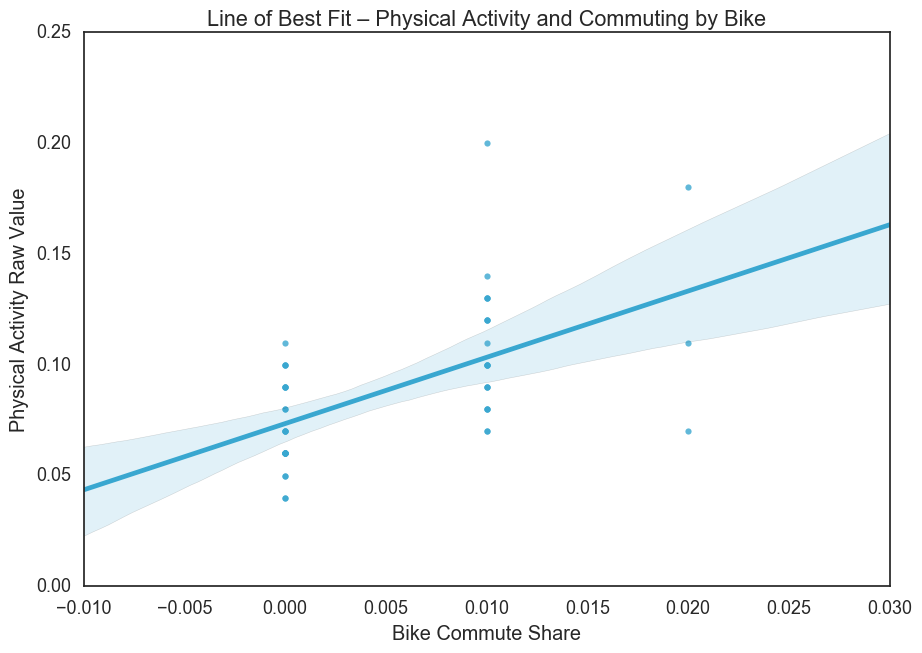

In [34]:
x = df['bike_share'].astype(float)
y = df['physical_raw'].astype(float)
ax = sns.regplot(x=x, y=y, data=df, color=p[5])
ax.set_title('Line of Best Fit – Physical Activity and Commuting by Bike')
ax.set(xlabel='Bike Commute Share', ylabel='Physical Activity Raw Value')
plt.show()

### Plot V: Line of Best Fit – Physical Activity and Commuting by Foot

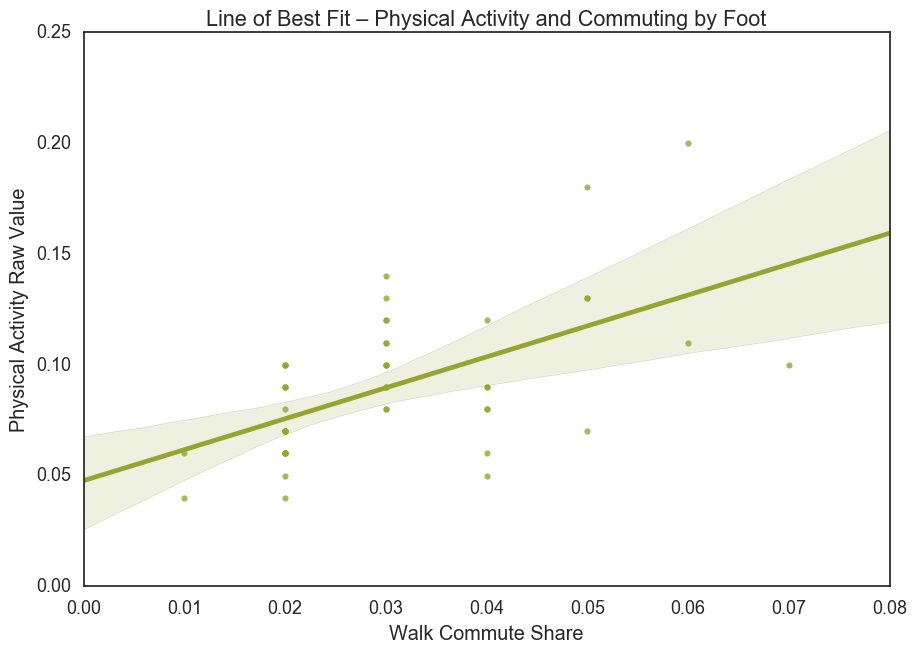

In [29]:
x = df['walk_share'].astype(float)
y = df['physical_raw'].astype(float)
ax = sns.regplot(x=x, y=y, data=df, color=p[2])
ax.set_title('Line of Best Fit – Physical Activity and Commuting by Foot')
ax.set(xlabel='Walk Commute Share', ylabel='Physical Activity Raw Value')
plt.show()

### Plot VI: Line of Best Fit – Physical Activity and Commuting by Public Transit

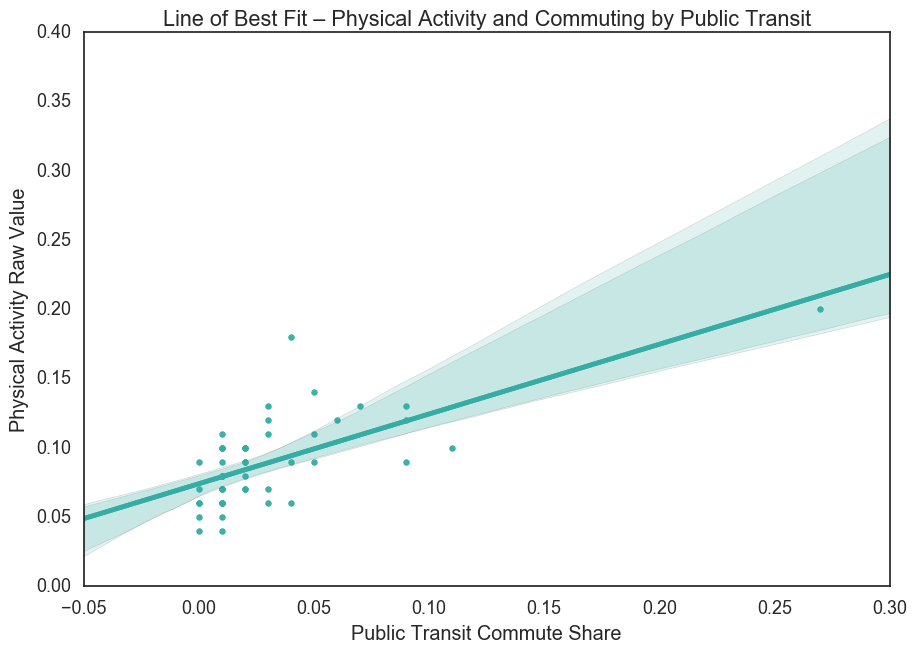

In [33]:
x = df['transit_share'].astype(float)
y = df['physical_raw'].astype(float)
ax = sns.regplot(x=x, y=y, data=df, color=p[4])
ax.set_title('Line of Best Fit – Physical Activity and Commuting by Public Transit')
ax.set(xlabel='Public Transit Commute Share', ylabel='Physical Activity Raw Value')
plt.show()

### Plot VII: Line of Best Fit – Physical Activity and Commuting by Car


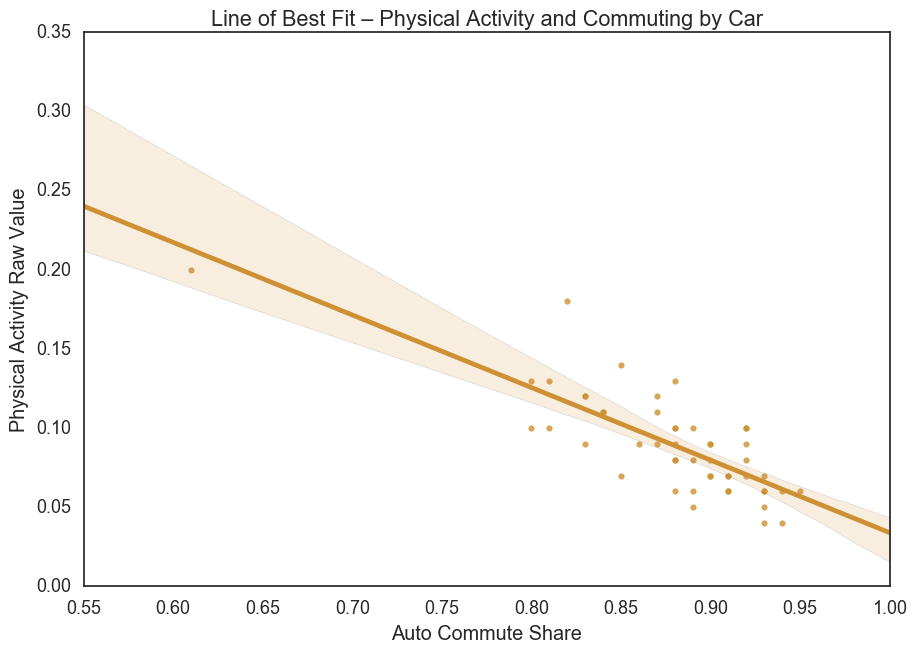

In [36]:
x = df['auto_share'].astype(float)
y = df['physical_raw'].astype(float)
ax = sns.regplot(x=x, y=y, data=df, color=p[1])
ax.set_title('Line of Best Fit – Physical Activity and Commuting by Car')
ax.set(xlabel='Auto Commute Share', ylabel='Physical Activity Raw Value')
plt.show()

The regression plots above indicate that biking, walking, and using public transit are loosely positively correlated with physical activity, and commuting by car is loosely negatively correlated with physical activity. 

### Plot VIII: Histogram - Complete Streets Policies

I'm also interested in seeing how Complete Streets Policies affect physical activity across the US. States and regions either enact those policies or they don't, and it's possible that those that do observe higher levels of alternative transportation.

In [40]:
x = df['CSP']
tr1 = Histogram(x=x, histnorm='probability', 
                xbins=dict(start=np.min(x), size= .99, end= np.max(x)),
                marker=dict(color='rgb(200, 200, 200)'))

title = "Historgram<br>Complete Streets Policy (Bernoulli)"

layout = dict(
            title=title,
            autosize= True,
            bargap= 0.01,
            height= 700,
            width= 900,       
            hovermode= 'x',
            xaxis=dict(
            autorange= True,
            zeroline= False),
            yaxis= dict(
            autorange= True,
            showticklabels= True,
           ))
fig = Figure(data=Data([tr1]), layout=layout)
py.iplot(fig, filename='Histogram Complete Streets Policy (Bernoulli)', validate=False)

# Regression Analysis and Diagnostics

My working hypothesis is that states with higher levels of bicycle commuting will tend to have higher levels of physical activity from transportation. This isn't groundbreaking work by any means, since physical activity from transportation is measured as walking or biking commutes that last 10 minutes or longer. That being said, since cycling is a very involved activity, I believe that cycling promotes staying active for longer periods of time. 

So with that in mind, let's combine everything we've observed up until this point, and build 3 iterations of the linear model,

$$ y = X\beta + \epsilon $$ <br>
where y is the response variable Physical Activity – Raw Value), and X is a vector of covariates. 

Heteroscedastically robust standard errors, fitted values vs. residuals plots, and Q-Q plots are applied to all iterations of the model for statistical validation.

### Regression Iteration 1: Estimating the effects of different commute modes on physical activity values

In this first iteration of the model, let's use all four commute modes as the covariates to see which are associated with physical mobility.

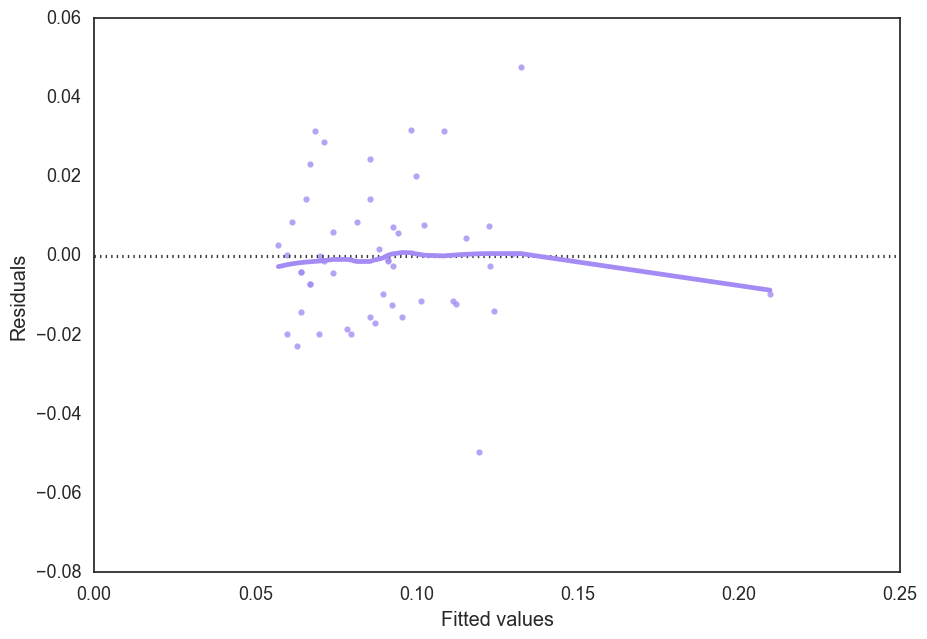

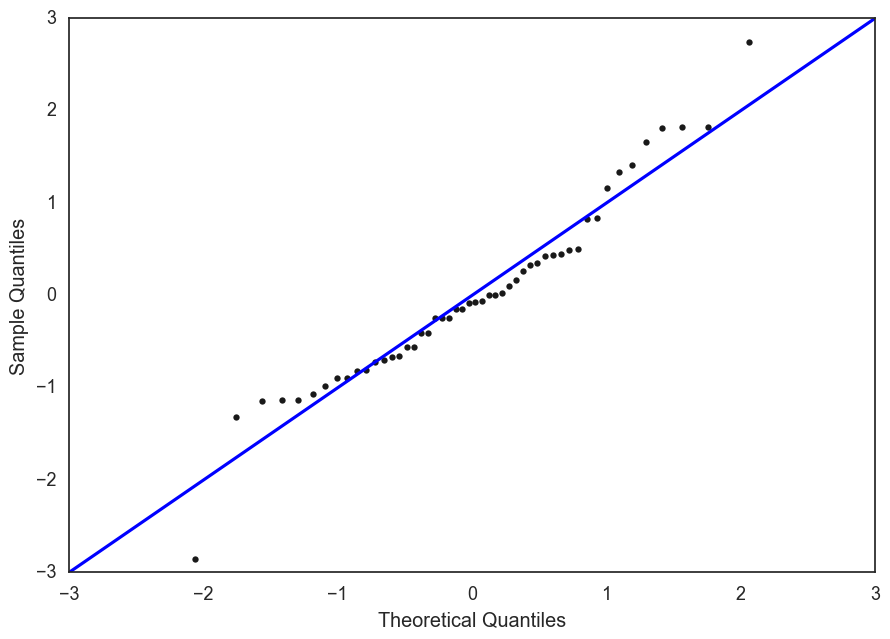

                            OLS Regression Results                            
Dep. Variable:           physical_raw   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     14.95
Date:                Thu, 17 Nov 2016   Prob (F-statistic):           7.61e-08
Time:                        03:08:07   Log-Likelihood:                 131.77
No. Observations:                  50   AIC:                            -253.5
Df Residuals:                      45   BIC:                            -244.0
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.1947      0.212      0.919

In [52]:
# Linear Regression Model
# Iteration 1 with Robust Standard Errors
np.asarray(df)
y = df['physical_raw']
X = df[['bike_share', 'walk_share', 'auto_share', 'transit_share']]
X = sm.add_constant(X)
mod = smf.OLS(y.astype(float), X.astype(float))
res = mod.fit(cov_type='HC3')

# Regression Diagnostics
# Fitted Values vs. Standardized Residuals Plot
residuals = res.resid
fitted = res.fittedvalues
ax = sns.residplot(fitted, residuals, lowess=True, color=p[6])
ax.set(xlabel='Fitted values', ylabel='Residuals')
plt.show()

# Q-Q Plot 
pp = sm.ProbPlot(residuals, fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='k', markeredgecolor='k', alpha=0.9)
sm.qqline(qq.axes[0], line='45', fmt='blue')
plt.show()

# Regression results
print(res.summary())

The first iteration of the model shows that bicycle commuting, with a point estimate of approximately 1.99, is the only commute mode statistically associated with physical activity (*p* < 0.05, Adjusted R-squared = 0.677). 

From the fitted values vs. residuals plot we see that the values appear to be randomly scattered around 0, but there's definitely an outlier or three in the mix. The one on the right is probably New York, with its significantly higher level of public transit commuting. The Q-Q plot seems reasonable, however.

### Regression Iteration 2: Estimating the effects of control covariates on physical activity values

In the second iteration of the model, I evaluate the relationship that alcohol-impared fatalities (DUI/DWI), proximity of major roadways, and use of federal funds for bicycle and pedestrian efforts have on levels of physical activity.

What should we expect? Well, it may be reasonable to assume that states with higher levels of physical activity will have lower alcohol-impared fatalities, lower levels of proximity to major roadways, and higher use of federal funds for bicycle and pedestrian efforts. 

But what does the data say? 

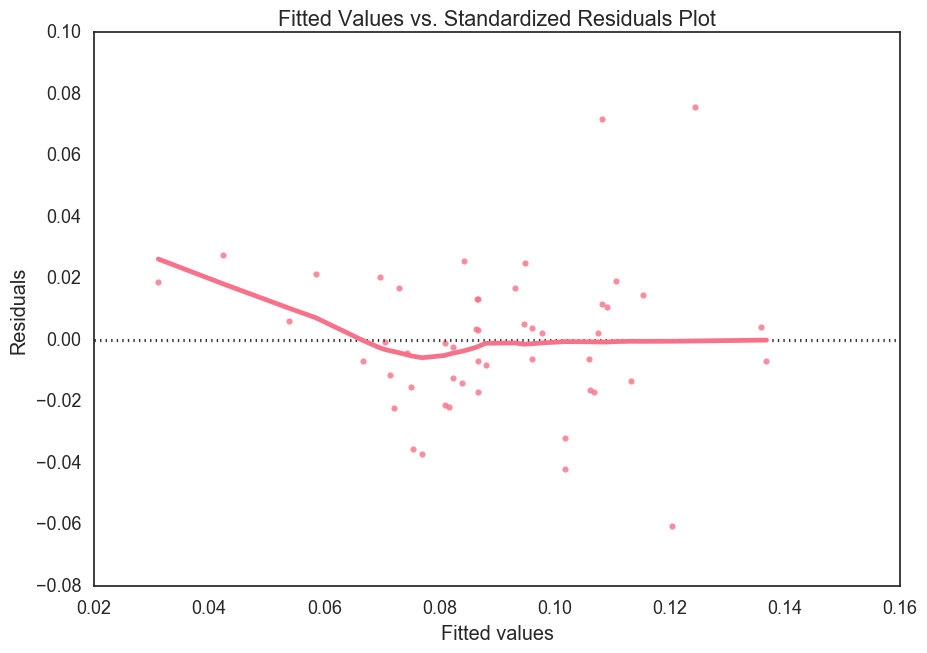

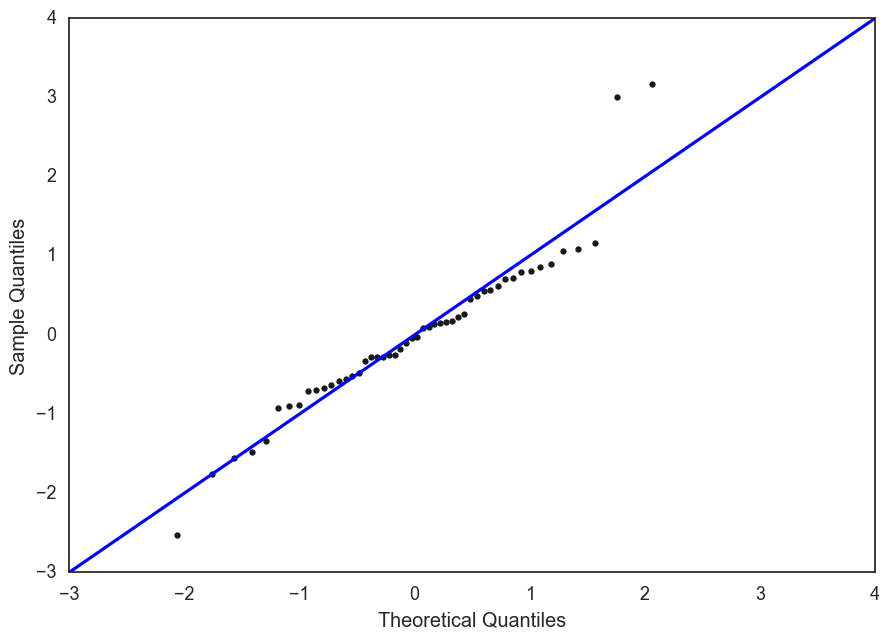

                            OLS Regression Results                            
Dep. Variable:           physical_raw   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     7.236
Date:                Wed, 16 Nov 2016   Prob (F-statistic):           0.000138
Time:                        23:10:45   Log-Likelihood:                 115.80
No. Observations:                  50   AIC:                            -221.6
Df Residuals:                      45   BIC:                            -212.0
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                0.1149      0.012  

In [33]:
# Linear Regression Model
# Iteration 2 with Robust Standard Errors
np.asarray(df)
y = df['physical_raw']
X = df[['CSP', 'duidwi_raw', 'proxmajorhwy_raw', 'funds_raw']]
X = sm.add_constant(X)
mod = smf.OLS(y.astype(float), X.astype(float))
res = mod.fit(cov_type='HC3')

# Regression Diagnostics
# Fitted Values vs. Standardized Residuals Plot
residuals = res.resid
fitted = res.fittedvalues
ax = sns.residplot(fitted, residuals, lowess=True, color=p[0])
ax.set_title('Fitted Values vs. Standardized Residuals Plot')
ax.set(xlabel='Fitted values', ylabel='Residuals')
plt.show()

# Q-Q Plot 
pp = sm.ProbPlot(residuals, fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='k', markeredgecolor='k', alpha=0.9)
sm.qqline(qq.axes[0], line='45', fmt='blue')
plt.show()

# Regression results
print(res.summary())

The second model suggests that states with higher levels of physical activity will have lower alcohol-impared fatalities (*p* < 0.000), and more proximity to major highways (*p* < 0.05). However, with an adjusted R-squared of 0.389 it's clear that this isn't that great of a model.  As a result, from just this iteration I wouldn't be comfortable asserting that the aforementioned relationships are reliable. 

### Regression Iteration 3: Estimating the effects of a curated set of covariates on physical activity values

In the final iteration of the model, a curated set of covariates is applied to maximize the adjusted R-squared and evaluate the best possible statistical model. The finalized list of covariates are: Bicycle commuting, auto commuting, alcohol-impared fatalities, proximity to major highways, and use of federal funds for bicycle and pedestrian efforts.

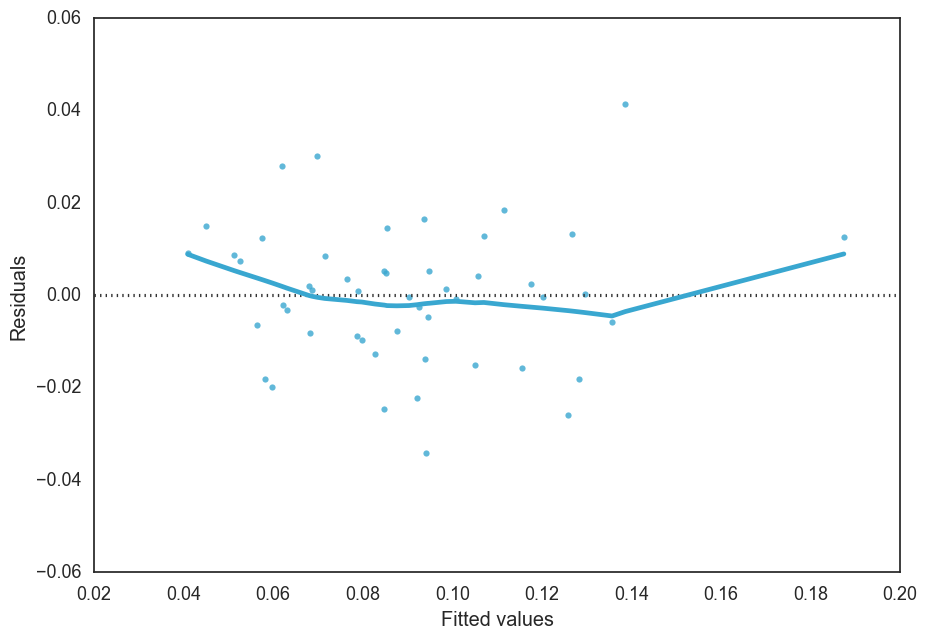

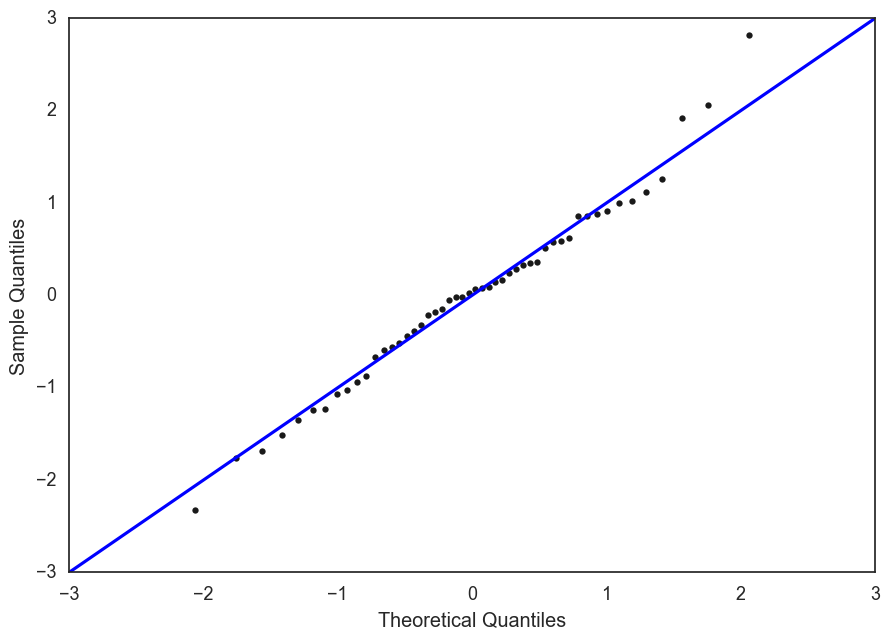

                            OLS Regression Results                            
Dep. Variable:           physical_raw   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     21.04
Date:                Wed, 16 Nov 2016   Prob (F-statistic):           1.11e-10
Time:                        23:10:12   Log-Likelihood:                 140.20
No. Observations:                  50   AIC:                            -268.4
Df Residuals:                      44   BIC:                            -256.9
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                0.3464      0.071  

In [32]:
### Linear Regression Model
# Iteration 3 with Robust Standard Errors
np.asarray(df)
y = df['physical_raw']
X = df[['bike_share', 'duidwi_raw', 'proxmajorhwy_raw', 'funds_raw', 'auto_share']]
X = sm.add_constant(X)
mod = smf.OLS(y.astype(float), X.astype(float))
res = mod.fit(cov_type='HC3')

# Regression Diagnostics
# Fitted Values vs. Standardized Residuals Plot
residuals = res.resid
fitted = res.fittedvalues
ax = sns.residplot(fitted, residuals, lowess=True, color=p[5])
ax.set(xlabel='Fitted values', ylabel='Residuals')
plt.show()

# Q-Q Plot 
pp = sm.ProbPlot(residuals, fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='k', markeredgecolor='k', alpha=0.9)
sm.qqline(qq.axes[0], line='45', fmt='blue')
plt.show()

# Regression results
print(res.summary())

The final iteration, with an adjusted R-squared of 0.765, suggests that states with higher levels of physical activity from transportation will have higher levels of bicycle commuting (*p* < 0.01), lower alcohol-impared fatalities (*p* < 0.01), and lower levels of commuting by car (*p* < 0.01). According to this model, proximity to major highways and use of federal funds for bicycle and pedestrian efforts are not statistically correlated with physical activity levels. 

The fitted values vs. residuals plot shows that there's no obvious heteroscedasticity in the model, but there's definitely one outlier present. Again, the Q-Q plot seems very reasonable. With the technical assumptions of the OLS model validated I can feel confident in the technical procedures. 